In [178]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
import seaborn as sns
from sympy import sqrt
from pynverse import inversefunc

In [2]:
ra, dec, pmra, pmdec = np.loadtxt('47tuc.dat', delimiter=' ', unpack=True)

In [3]:
ra *= u.degree
dec *= u.degree
pmra *= u.mas / u.yr
pmdec *= u.mas / u.yr

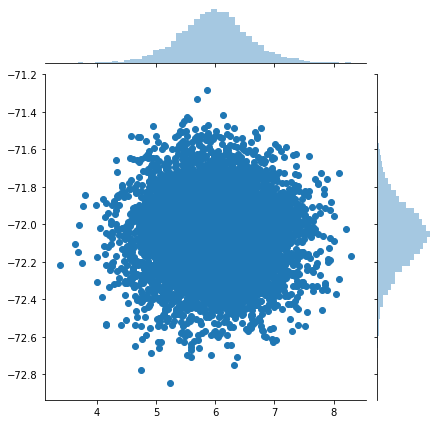

In [4]:
sns.jointplot(ra, dec)

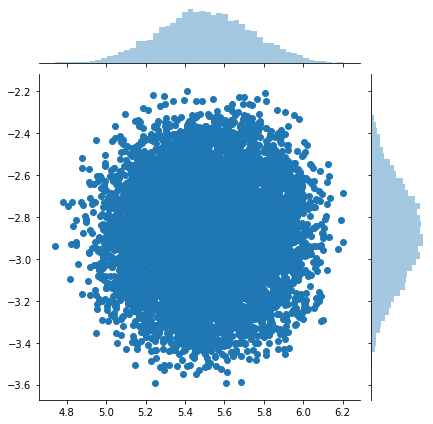

In [5]:
sns.jointplot(pmra, pmdec)

In [6]:
dat = SkyCoord(ra=ra, dec=dec, pm_ra_cosdec=pmra, pm_dec=pmdec, distance=4.5e3*u.pc, frame='icrs')

In [7]:
dat.ra.mean(), dat.dec.mean()

(<Longitude 5.98103123 deg>, <Latitude -72.0564269 deg>)

In [8]:
# pm in mas/yr
dat.pm_ra_cosdec.mean(), dat.pm_dec.mean()

(<Quantity 5.50376091 mas / yr>, <Quantity -2.88491744 mas / yr>)

In [9]:
# pm in km/s
dat.pm_ra_cosdec.mean()* 4.5 * 4.744, dat.pm_dec.mean()* 4.5 * 4.744 

(<Quantity 117.49428784 mas / yr>, <Quantity -61.58721747 mas / yr>)

In [10]:
ra2 = ra - ra.mean()
dec2 = dec - dec.mean()
pmra2 = pmra - pmra.mean()
pmdec2 = pmdec - pmdec.mean()

In [11]:
dists2center = (ra2 * 4.5 * u.kpc).to(u.pc, equivalencies=u.dimensionless_angles())
dists2center

<Quantity [ 17.87391594,  39.47448273, -95.29191673, ...,  15.58392938,
            21.29088425, -42.80492225] pc>

In [12]:
totprojvels = np.sqrt(np.square(pmra2) + np.square(pmdec2))
totprojvels *= 4.5 * u.kpc
totprojvels = totprojvels.to(u.km / u.s, equivalencies=u.dimensionless_angles())
totprojvels

<Quantity [ 3.71559255,  1.27915989,  2.98010031, ...,  7.15487126,
           15.47369425,  5.7960866 ] km / s>

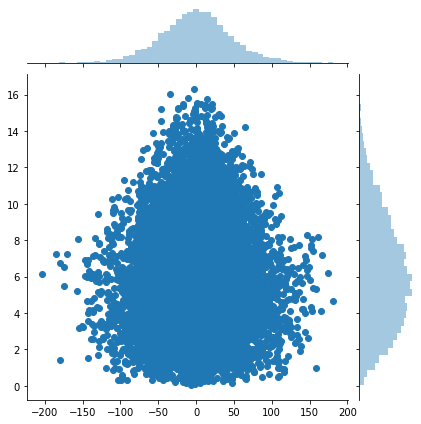

In [13]:
sns.jointplot(dists2center, totprojvels)

In [14]:
vsq = 3 * np.var(totprojvels)
vsq = vsq.to(u.m **2 / u.s ** 2)
r = np.max(abs(dists2center)).to(u.m) # use mean or max?

In [15]:
mass = vsq * r / const.G
mass

<Quantity 2.60105303e+36 kg>

In [16]:
lum = const.L_sun * 100 ** ((4.83 + 9.42) / 5)
lum

<Quantity 1.91854473e+32 W>

In [17]:
(mass / const.M_sun) / (lum / const.L_sun) # seems high?

<Quantity 2.61001676>

In [276]:
def theta(beta, einstein): # can use sympy.sqrt instead to give exact solution
    return (beta + np.sqrt(beta**2 + 4*einstein**2)) / 2, (beta - np.sqrt(beta**2 + 4*einstein**2)) / 2

In [247]:
def einstein(ds, dd, m):
    dds = ds - dd
    return np.sqrt((4 * const.G * m * dds) / (ds * dd * const.c ** 2)) * u.rad

#yes, the above works. units all work.
#below is for sanity check
# def ein2(ds, dd, m): 
#     dds = ds - dd
#     return np.sqrt(4 * 6.67e-11 * m * dds / (ds * dd * 2.998e8 ** 2))

In [268]:
thetae = einstein(10 * u.kpc, 5 * u.kpc, 1 * u.M_sun).to(u.rad)

In [261]:
thetae.value

4.375118668847891e-09

[0.6180339887498948, 0.0990195135927851, 0.009999000199951948, 0.0009999990000275506]


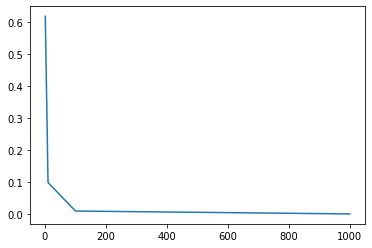

In [278]:
xs = np.array([1, 10, 100, 1000])
ys = [np.min(np.abs(theta(i * thetae.value, thetae.value))) / thetae.value for i in xs]
print(ys)
plt.plot(xs, ys)
# limit is 0 as beta -> infty

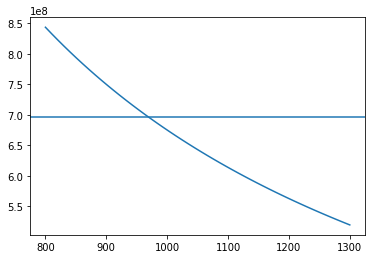

In [319]:
x = np.linspace(800, 1300)
y = [np.min(np.abs(theta(i*thetae.value, thetae.value))) * (5*u.kpc).to(u.m).value for i in x]
plt.plot(x, y)
plt.axhline(const.R_sun.value)

In [320]:
gety = lambda x: np.min(np.abs(theta(x*thetae.value, thetae.value))) * (5*u.kpc).to(u.m).value
getx = inversefunc(gety)

In [321]:
getx(const.R_sun.value) # beta

/usr/local/lib/python3.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  % accuracy, RuntimeWarning)


array(970.25954704)

In [325]:
gety(970.26) # checking

695699670.8571526

In [350]:
# just use this one. the actual formula. dont bother with the inverse stuff.
t = (const.R_sun / (5 * u.kpc)).to(u.dimensionless_unscaled)
b = t - thetae.value / t
b # why negative? 

<Quantity -970.26057156>

In [351]:
gety(-970.26) # doesnt matter. the += in the quadratic makes sure that you take the right one as the minimum one.

695699670.8571526

In [353]:
np.min(np.abs(theta(970.26*thetae.value, thetae.value))) #theta

4.509218170009572e-12

In [331]:
(970.26 * thetae).to(u.mas) # beta in mas

<Quantity 875.59464698 mas>

In [332]:
def magn(beta, einstein):
    return 1/4 * (beta / np.sqrt(beta**2 + 4 * einstein**2) + np.sqrt(beta**2 + 4*einstein**2) / beta + 2), 1/4 * (beta / np.sqrt(beta**2 + 4 * einstein**2) + np.sqrt(beta**2 + 4*einstein**2) / beta - 2)

In [341]:
ys2 = np.array([magn(i*thetae.value, thetae.value) for i in xs])
# limit of magnification is 1, 0

array([[1.17082039e+00, 1.70820393e-01],
       [1.00009614e+00, 9.61446024e-05],
       [1.00000001e+00, 9.99600158e-09],
       [1.00000000e+00, 9.99977878e-13]])